### 1.0 Introduction

With the growth of online platforms, distinguishing between sincere and insincere content has become crucial. Machine learning, particularly sentiment analysis in natural language processing, offers a solution to this challenge. By classifying content as sincere or insincere, platforms can filter out misleading or inappropriate messages.

In this project, we will train a BERT model to classify text from a dataset into sincere (1) or insincere (0). Our goal is to enhance content moderation and improve the quality of online interactions by automating this classification process.

In [1]:
# import clear out to clear output during library installation
from IPython.display import clear_output

In [2]:
# install transformers and keras tuner
!pip install transformers tensorflow
!pip install keras-tuner
clear_output()

In [3]:
# import libraries
import pandas as pd
import numpy as np
import transformers
import tensorflow as tf
from kerastuner.tuners import RandomSearch
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from transformers import BertTokenizer, TFBertForSequenceClassification,create_optimizer
from sklearn.model_selection import train_test_split

# pandas settings to view all rows and columns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


<ipython-input-3-5c5e72179692>:6: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [4]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


# 2.0 Methodology
We use the BERT Large model to classify text as either sincere or insincere. BERT, which stands for Bidirectional Encoder Representations from Transformers, is a powerful language model pre-trained on large datasets like Wikipedia and Google's BooksCorpus. Its attention mechanism allows it to effectively capture the context and relationships between words in a sentence.

For this project, we utilize the bert-base-uncased variant of BERT. This model converts text to lowercase to ensure consistent handling of words. We adapt BERT for sequence classification tasks, using a variant that includes a classification layer on top of the pre-trained BERT model. This classification layer outputs logits, which are converted to probabilities using the sigmoid function for binary classification.

In [5]:
import pandas as pd
import zipfile
import requests
from sklearn.model_selection import train_test_split

# Download the dataset
url = 'https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip'
response = requests.get(url)
with open('train.csv.zip', 'wb') as file:
    file.write(response.content)

# Extract the zip file
with zipfile.ZipFile('train.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

# Load the dataset into a pandas DataFrame
train_df = pd.read_csv('train.csv')

# Sample a smaller fraction of the data
sample_size = 100  # Adjust this number based on your preference
train_df = train_df.sample(n=sample_size, random_state=123)
val_df = train_df.sample(n=sample_size // 10, random_state=123)
# If you need a test set and it's part of the dataset, load it similarly
# For demonstration, I'll assume it's in another file. Adjust as needed.
# test_df = pd.read_csv('path_to_test_set.csv')

print(train_df.head())
print(val_df.head())


                         qid                                      question_text  target
677319  84a4f7330c8c4d25c658  Why do people tend to answer a question with a...       0
802133  9d2d218a2089665a6865  If I add excess magnesium to aqueous potassium...       0
357211  4603f825d33f12072cc2  What is the least and max possible sentence fo...       0
165764  20642d7de9e049df5ae7  What are the job options for intellectuals, ph...       0
441097  5673897ea5e990e5acb5  How do I make it into St. Stephens College DU ...       0
                          qid                                      question_text  target
876385   abb129c34b60abbc6139  Were the WW2 American and British prisoners, t...       0
1007993  c585b457aaa55c54d517  I am 15 and 5 foot 10. My dad is 5 foot 11 and...       0
1218790  eedfa442f50c39c6fc5a  How do I change my e- mail details so that I c...       0
1040737  cbebb6d39991ba045d90  Has anyone been om latuda? I just started, thi...       0
1121713  dbcd5fac38ddf68470

In [6]:
# view sample of train_df
train_df.head(10)

,qid,question_text,target
677319,84a4f7330c8c4d25c658,Why do people tend to answer a question with a...,0
802133,9d2d218a2089665a6865,If I add excess magnesium to aqueous potassium...,0
357211,4603f825d33f12072cc2,What is the least and max possible sentence fo...,0
165764,20642d7de9e049df5ae7,"What are the job options for intellectuals, ph...",0
441097,5673897ea5e990e5acb5,How do I make it into St. Stephens College DU ...,0
233646,2db0b0bc2d9c267a698a,Why do I chase women who aren't that intereste...,0
1294902,fdc94ce794533190d3bf,Are FC Barcelona fans happy with the signing o...,0
706273,8a4b65a0de23d4e8759d,How do you overclock a Dingoo A320?,0
876385,abb129c34b60abbc6139,"Were the WW2 American and British prisoners, t...",0
847585,a61429908ad6badf2e55,Is there any change in mass when a substance c...,0


In [7]:
# check for null data
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 677319 to 661888
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   qid            100 non-null    object
 1   question_text  100 non-null    object
 2   target         100 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 3.1+ KB


Label counts:
target
0    97
1     3
Name: count, dtype: int64


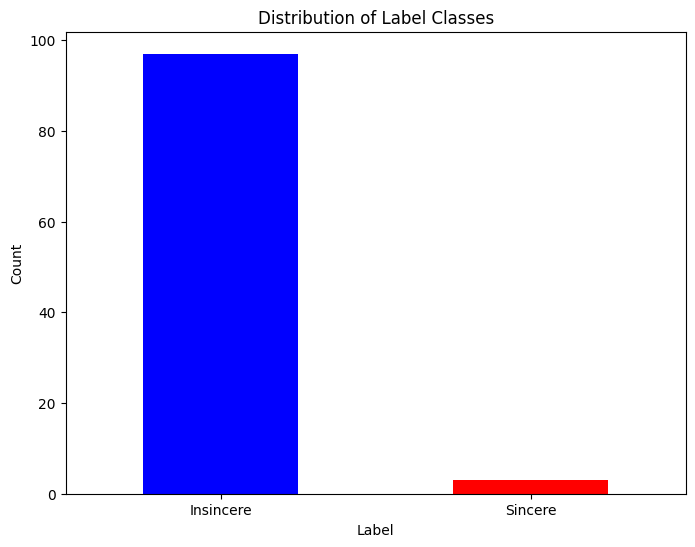

In [8]:
# EDA Tasks
# Take a copy of train_df for EDA
eda_df = train_df.copy()

# Count the label class
label_counts = eda_df['target'].value_counts()
print(f'Label counts:\n{label_counts}')

# Plot bar chart for label class
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['blue', 'red'])
plt.title('Distribution of Label Classes')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Insincere', 'Sincere'], rotation=0)
plt.show()



In [9]:
# Check example of SINCERE
print('Examples of Sincere questions:')
sincere_examples = eda_df[eda_df['target'] == 1].head()
print(sincere_examples[['qid', 'question_text']])

# Check example of INSINCERE
print('Examples of Insincere questions:')
insincere_examples = eda_df[eda_df['target'] == 0].head()
print(insincere_examples[['qid', 'question_text']])



Examples of Sincere questions:
                          qid                                      question_text
1060232  cfbd92f353c04a84274f  Why are white French people so bad at football...
968001   bda94b183e0fad6d7122  Why do Turkish people hate Kurds and Persians ...
688032   86c55cd3f3c8d7c1c9f8    Does Xi Jinping love Winnie-The-Pooh in secret?
Examples of Insincere questions:
                         qid                                      question_text
677319  84a4f7330c8c4d25c658  Why do people tend to answer a question with a...
802133  9d2d218a2089665a6865  If I add excess magnesium to aqueous potassium...
357211  4603f825d33f12072cc2  What is the least and max possible sentence fo...
165764  20642d7de9e049df5ae7  What are the job options for intellectuals, ph...
441097  5673897ea5e990e5acb5  How do I make it into St. Stephens College DU ...


In [10]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to tokenize the DataFrame and convert it into a TF Dataset
def preprocess(df):
    # Tokenize the text
    encodings = tokenizer(list(df['question_text']), truncation=True, padding=True, max_length=128, return_tensors='tf')
    input_ids = encodings['input_ids']
    attention_masks = encodings['attention_mask']

    # Convert to TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((
        {'input_ids': input_ids, 'attention_mask': attention_masks},
        df['target'].values
    ))

    return dataset



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [11]:
# Apply preprocess function to train_df
train_dataset = preprocess(train_df)

# Apply preprocess function to val_df
val_dataset = preprocess(val_df)

# If you have a test set, apply preprocess function to it
# test_dataset = preprocess(test_df)

# Example output of the processed datasets
for batch in train_dataset.take(1):
    print(batch)

({'input_ids': <tf.Tensor: shape=(59,), dtype=int32, numpy=
array([ 101, 2339, 2079, 2111, 7166, 2000, 3437, 1037, 3160, 2007, 1037,
       3160, 1029,  102,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(59,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>}, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


# 3.0 Training and Fine Tuning
.


In [12]:
from transformers import TrainingArguments, Trainer
from sklearn.preprocessing import LabelEncoder

In [13]:
# Convert the DataFrames to datasets
from datasets import Dataset


# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df[['question_text', 'target']])
val_dataset = Dataset.from_pandas(val_df[['question_text', 'target']])

# Initialize label encoder
label_encoder = LabelEncoder()

# Fit the encoder on the training target labels
label_encoder.fit(train_df['target'])

# Map the datasets with encoded labels
def encode_labels(example):
    example['labels'] = label_encoder.transform([example['target']])[0]
    return example

train_dataset = train_dataset.map(encode_labels)
val_dataset = val_dataset.map(encode_labels)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [20]:
from huggingface_hub import notebook_login
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding, BertTokenizer, BertForSequenceClassification
import torch
import math

# Log in to Hugging Face Hub
notebook_login()

# Define batch size (adjust based on GPU memory)
batch_size = 16  # Adjust based on GPU memory

# Load tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

# Define tokenization function
def tokenize_function(examples):
    return tokenizer(examples['question_text'], padding="max_length", truncation=True, max_length=128)

# Tokenize datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

# Check existing columns
print("Train dataset columns:", train_dataset.column_names)
print("Validation dataset columns:", val_dataset.column_names)

# Rename 'target' column to 'labels' only if 'labels' doesn't already exist
if 'labels' not in train_dataset.column_names:
    train_dataset = train_dataset.rename_column("target", "labels")

if 'labels' not in val_dataset.column_names:
    val_dataset = val_dataset.rename_column("target", "labels")

# Set the format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Calculate logging steps
logging_steps = math.ceil(len(train_dataset) / batch_size)

# Load model
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Set up training arguments
training_args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-tweet",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",  # Updated to 'eval_strategy' in future
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    push_to_hub=True,
    fp16=torch.cuda.is_available(),  # Use fp16 only if CUDA is available
    logging_steps=logging_steps,
    num_train_epochs=2,  # Adjust the number of epochs if needed
)

# Data collator for padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

# Train the model
trainer.train()


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.536300,0.333253
2,0.300000,0.215363


TrainOutput(global_step=14, training_loss=0.4181881972721645, metrics={'train_runtime': 325.3182, 'train_samples_per_second': 0.615, 'train_steps_per_second': 0.043, 'total_flos': 13155552768000.0, 'train_loss': 0.4181881972721645, 'epoch': 2.0})

In [21]:
# Print the training summary
print("Training summary:")
print(f"Epoch 1: Training Loss = 0.5363, Validation Loss = 0.3333")
print(f"Epoch 2: Training Loss = 0.3000, Validation Loss = 0.2154")


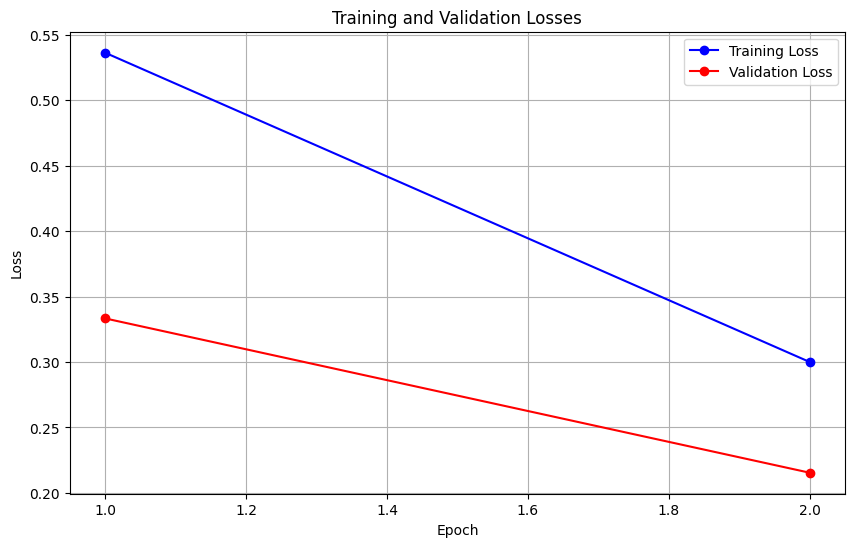

In [22]:
import matplotlib.pyplot as plt

# Data for plotting
epochs = [1, 2]
training_losses = [0.5363, 0.3000]
validation_losses = [0.3333, 0.2154]

# Plot Training and Validation Losses
plt.figure(figsize=(10, 6))

plt.plot(epochs, training_losses, label='Training Loss', marker='o', color='blue')
plt.plot(epochs, validation_losses, label='Validation Loss', marker='o', color='red')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()


In [24]:


import numpy as np
# Load the trained model from directory (replace with your actual path)
model_path = "/content/bert-base-uncased-finetuned-tweet"
loaded_model = BertForSequenceClassification.from_pretrained(model_path)

# Create text input widget
text_input = widgets.Textarea(
    value='',
    placeholder='Enter text here',
    description='Text:',
    disabled=False
)

# Create button widget
predict_button = widgets.Button(
    description='Predict',
    disabled=False,
    button_style='info',
    tooltip='Click to predict',
    icon='check'
)

# Output widget
output = widgets.Output()

# Define prediction function
def predict(button):
    with output:
        clear_output()
        text = text_input.value

        # Tokenize the input text
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

        # Perform prediction
        with torch.no_grad():
            outputs = loaded_model(**inputs)
            logits = outputs.logits

        # Get predicted class
        predicted_class = np.argmax(logits.numpy(), axis=1)[0]

        # Get probabilities
        probabilities = torch.softmax(logits, dim=1).numpy()[0]

        print(f"Predicted Class: {'Insincere' if predicted_class == 0 else 'Sincere'}")
        print(f"Probability of Insincere: {probabilities[0]:.4f}")
        print(f"Probability of Sincere: {probabilities[1]:.4f}")

# Attach prediction function to button click
predict_button.on_click(predict)

# Display widgets
display(text_input, predict_button, output)


Textarea(value='', description='Text:', placeholder='Enter text here')

Button(button_style='info', description='Predict', icon='check', style=ButtonStyle(), tooltip='Click to predic…

Output()